In [91]:
### READING DATA FROM INPUT

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# remove warning!!
pd.options.mode.chained_assignment = None  # default='warn'


import os
# print(os.listdir("../input"))
df = pd.read_csv("../input/train.csv", index_col=[0])
testData = pd.read_csv("../input/test.csv")
### DESCRIPTION OF DATA
df.describe(include="all")

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
count,604,3.000000e+03,2993,946,3000,3000,3000,2992,3000.000000,2999,2844,2945,3000,2998.000000,2980,3000,2403,3000,2724,2987,2984,3.000000e+03
unique,422,NaN,872,941,3000,36,2975,2992,NaN,2999,2383,321,2398,NaN,401,2,2400,2969,2648,2975,2984,NaN
top,"[{'id': 645, 'name': 'James Bond Collection', ...",NaN,"[{'id': 18, 'name': 'Drama'}]",http://www.transformersmovie.com/,tt0765120,en,Hot Pursuit,When Kimberly has a violent premonition of a h...,NaN,/pVVNkP7iA0BMvlqt3xJPSLnEqjW.jpg,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States o...",9/10/15,NaN,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Alone in the Dark,"[{'id': 10183, 'name': 'independent film'}]",[],"[{'credit_id': '52fe45849251416c750594bd', 'de...",NaN
freq,16,NaN,266,4,1,2575,2,1,NaN,1,51,1752,5,NaN,1817,2996,3,2,27,13,1,NaN
mean,NaN,2.253133e+07,NaN,NaN,NaN,NaN,NaN,NaN,8.463274,NaN,NaN,NaN,NaN,107.856571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.672585e+07
std,NaN,3.702609e+07,NaN,NaN,NaN,NaN,NaN,NaN,12.104000,NaN,NaN,NaN,NaN,22.086434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.375323e+08
min,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,4.018053,NaN,NaN,NaN,NaN,94.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.379808e+06
50%,NaN,8.000000e+06,NaN,NaN,NaN,NaN,NaN,NaN,7.374861,NaN,NaN,NaN,NaN,104.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.680707e+07
75%,NaN,2.900000e+07,NaN,NaN,NaN,NaN,NaN,NaN,10.890983,NaN,NaN,NaN,NaN,118.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.891920e+07


In [92]:
### DATA PREPARATION ###
def prepare(df):
    global json_cols
    global train_dict

    ### separate release date into year, month, day
    df[['release_month','release_day','release_year']]=df['release_date'].str.split('/',expand=True).replace(np.nan, 0).astype(int)
    df['release_year'] = df['release_year']
    df.loc[ (df['release_year'] <= 18) & (df['release_year'] < 100), "release_year"] += 2000
    df.loc[ (df['release_year'] > 18)  & (df['release_year'] < 100), "release_year"] += 1900
    ###

    ### add ratio datas for correlations
    meanRuntime = df['runtime'].mean()
    df.loc[ df['runtime'] == 0 ,'runtime'] = meanRuntime
    df['_budget_runtime_ratio'] =  df['budget']/df['runtime']
    df['_budget_popularity_ratio'] = df['budget']/df['popularity']
    df['_budget_year_ratio'] = df['budget']/(df['release_year'])
    df['_releaseYear_popularity_ratio'] = df['release_year']/df['popularity']
    df['_popularity_releaseYear_ratio'] = df['popularity']/df['release_year']
    ###

    ### add binary fields for descriptive data
    df['isMovieReleased'] = 1
    df.loc[ df['status'] != "Released" ,"isMovieReleased"] = 0 

    df['isOriginalLanguageEng'] = 0 
    df.loc[ df['original_language'] == "en" ,"isOriginalLanguageEng"] = 1
    ###

    ### add mean data
    df['meanRuntimeByYear'] = df.groupby("release_year")["runtime"].aggregate('mean')
    ###
    
    df = df.drop(['belongs_to_collection','genres','homepage','overview', 'imdb_id'
    ,'poster_path','production_companies','production_countries','release_date','spoken_languages'
    ,'status','title','Keywords','cast','crew','original_language','original_title','tagline'
    ],axis=1)
    
    df.fillna(value=0.0, inplace = True) 
    df.fillna(value=0.0, inplace = True) 
    return df

# all_data = prepare(pd.concat([df, testData], sort=True).reset_index(drop = True))
train = prepare(df)
train['id'] = range(1, len(train) + 1)
train.index = train['id']

test = prepare(testData)
test['id'] = range(1, len(test) + 1)
test.index = test['id']


### END OF DATA PREPARATION ###
# data after preparation:
features = list(train.columns)
features =  [i for i in features if i != 'id' and i != 'revenue']
print("*** Features are:")
print(train.dtypes)
train.describe(include="all")

*** Features are:
budget                             int64
popularity                       float64
runtime                          float64
revenue                            int64
release_month                      int64
release_day                        int64
release_year                       int64
_budget_runtime_ratio            float64
_budget_popularity_ratio         float64
_budget_year_ratio               float64
_releaseYear_popularity_ratio    float64
_popularity_releaseYear_ratio    float64
isMovieReleased                    int64
isOriginalLanguageEng              int64
meanRuntimeByYear                float64
id                                 int64
dtype: object


,budget,popularity,runtime,revenue,release_month,release_day,release_year,_budget_runtime_ratio,_budget_popularity_ratio,_budget_year_ratio,_releaseYear_popularity_ratio,_popularity_releaseYear_ratio,isMovieReleased,isOriginalLanguageEng,meanRuntimeByYear,id
count,3.000000e+03,3000.000000,3000.000000,3.000000e+03,3000.000000,3000.000000,3000.000000,3.000000e+03,3.000000e+03,3000.000000,3.000000e+03,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.000000
mean,2.253133e+07,8.463274,108.216093,6.672585e+07,6.775333,15.046333,1999.713000,1.997039e+05,3.133035e+06,11237.061369,6.693419e+05,4.227358e-03,0.998667,0.858333,3.309792,1500.500000
std,3.702609e+07,12.104000,21.179382,1.375323e+08,3.409115,8.632981,15.423313,3.115421e+05,1.104647e+07,18432.070332,3.629592e+07,6.009040e-03,0.036497,0.348766,19.040728,866.169729
min,0.000000e+00,0.000001,0.000000,1.000000e+00,1.000000,1.000000,1921.000000,0.000000e+00,0.000000e+00,0.000000,6.852688e+00,5.030181e-10,0.000000,0.000000,0.000000,1.000000
25%,0.000000e+00,4.018053,94.000000,2.379808e+06,4.000000,8.000000,1993.000000,0.000000e+00,0.000000e+00,0.000000,1.837562e+02,2.012961e-03,1.000000,1.000000,0.000000,750.750000
50%,8.000000e+06,7.374861,104.000000,1.680707e+07,7.000000,15.000000,2004.000000,7.164243e+04,1.192733e+06,3980.099502,2.710090e+02,3.689915e-03,1.000000,1.000000,0.000000,1500.500000
75%,2.900000e+07,10.890983,118.000000,6.891920e+07,10.000000,22.000000,2011.000000,2.659574e+05,3.789107e+06,14404.650576,4.967813e+02,5.441993e-03,1.000000,1.000000,0.000000,2250.250000
max,3.800000e+08,294.337037,338.000000,1.519558e+09,12.000000,31.000000,2017.000000,2.794118e+06,4.320028e+08,188960.716062,1.988000e+09,1.459281e-01,1.000000,1.000000,152.800000,3000.000000


In [93]:
### K-FOLD Class Decleration
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error

def score(data, y):
    validation_res = pd.DataFrame(
    {"id": data["id"].values,
     "transactionrevenue": data["revenue"].values,
     "predictedrevenue": np.expm1(y)})

    validation_res = validation_res.groupby("id")["transactionrevenue", "predictedrevenue"].sum().reset_index()
    return np.sqrt(mean_squared_error(np.log1p(validation_res["transactionrevenue"].values), 
                                     np.log1p(validation_res["predictedrevenue"].values)))

class KFoldValidation():
    def __init__(self, data, n_splits=5):
        unique_vis = np.array(sorted(data['id'].astype(str).unique()))
        folds = GroupKFold(n_splits)
        ids = np.arange(data.shape[0])
        
        self.fold_ids = []
        for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
            self.fold_ids.append([
                    ids[data['id'].astype(str).isin(unique_vis[trn_vis])],
                    ids[data['id'].astype(str).isin(unique_vis[val_vis])]
                ])
            
    def validate(self, train, test, features, model, name="", prepare_stacking=False, 
                 fit_params={"early_stopping_rounds": 500, "verbose": 0, "eval_metric": "rmse"}):
        model.FI = pd.DataFrame(index=features)
        full_score = 0
        
        if prepare_stacking:
            test[name] = 0
            train[name] = np.NaN
        
        for fold_id, (trn, val) in enumerate(self.fold_ids):
            devel = train[features].iloc[trn]
            y_devel = np.log1p(train["revenue"].iloc[trn])
            valid = train[features].iloc[val]
            y_valid = np.log1p(train["revenue"].iloc[val])
                       
            #print("Fold ", fold_id, ":")
            model.fit(devel, y_devel, eval_set=[(valid, y_valid)], **fit_params)
            
            if len(model.feature_importances_) == len(features):  # some bugs in catboost?
                model.FI['fold' + str(fold_id)] = model.feature_importances_ / model.feature_importances_.sum()

            predictions = model.predict(valid)
            predictions[predictions < 0] = 0
            #print("Fold ", fold_id, " error: ", mean_squared_error(y_valid, predictions)**0.5)
            
            fold_score = score(train.iloc[val], predictions)
            full_score += fold_score / len(self.fold_ids)
            #print("Fold ", fold_id, " score: ", fold_score)
            
            if prepare_stacking:
                train[name].iloc[val] = predictions
                
                test_predictions = model.predict(test[features])
                test_predictions[test_predictions < 0] = 0
                test[name] += test_predictions / len(self.fold_ids)
                
        print("Final score: ", full_score)
        return full_score

KfoldResult = KFoldValidation(train)

In [94]:
### K-Fold Validation with lightgbm
import lightgbm as lgb

lgbmodel = lgb.LGBMRegressor(n_estimators=10000, 
                             objective="regression", 
                             metric="rmse", 
                             num_leaves=20, 
                             min_child_samples=100,
                             learning_rate=0.01, 
                             bagging_fraction=0.8, 
                             feature_fraction=0.8, 
                             bagging_frequency=1, 
                             bagging_seed=2019, 
                             subsample=.9, 
                             colsample_bytree=.9,
                             use_best_model=True)

KfoldResult.validate(train, test, features , lgbmodel, name="lgbfeatures", prepare_stacking=True) 


Final score:  2.134983609249497


2.134983609249497

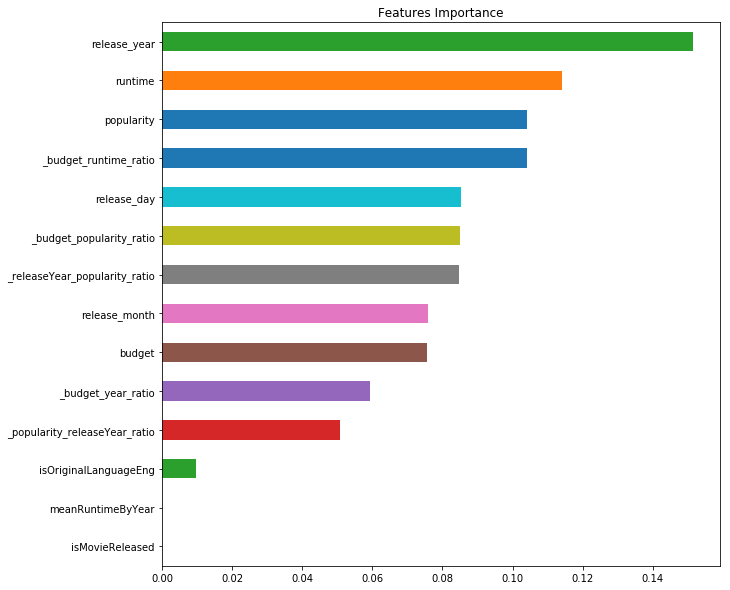

In [95]:
### plot features importance
sortedFeatureValues = lgbmodel.FI.mean(axis=1).sort_values()
sortedFeatureValues.plot(kind="barh",title = "Features Importance", figsize = (10,10));


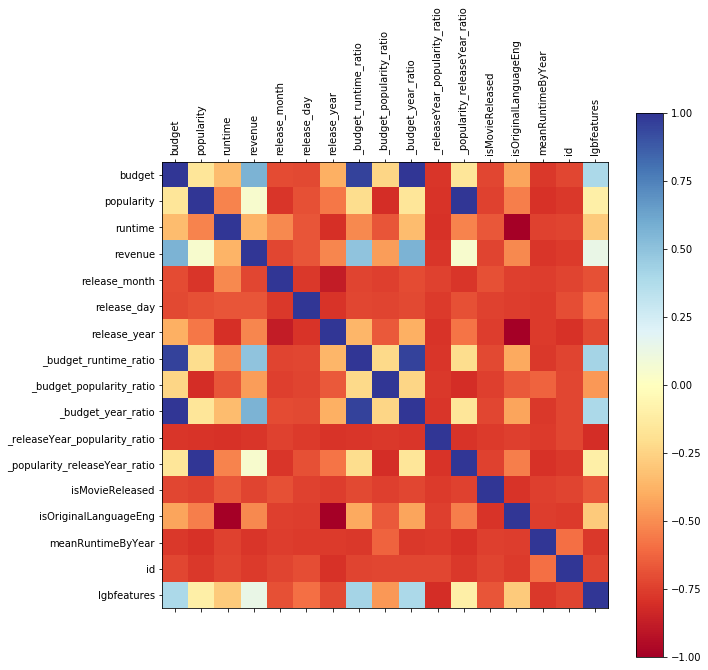

In [96]:
### Correlation matrix
from pandas.plotting import scatter_matrix

def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig = plt.figure(figsize=(size, size))
    ax = fig.add_subplot(111)
    cmap = plt.cm.get_cmap('RdYlBu')
    cax = ax.matshow(corr, vmin=-1, vmax=1, cmap=cmap)
    fig.colorbar(cax)
    ax.matshow(corr, cmap=cmap)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical');
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.show()

### WAY 1 ###
plot_corr(train, 10)

### WAY 2 ###
#corr = train.corr()
#corr.style.background_gradient(cmap='coolwarm').set_precision(2)

### WAY 3 ###
# scatter_matrix(train)

based on correlation matrix, revenue is more related to **budget**, **budget_runtime_ratio** and **budget_year_ratio**.

In [97]:
def trainWithModel(X, Y, testX, features, target, model, modelName):    
    predictY = model.predict(testX)

    for feature in features:
        testResults = pd.DataFrame(data=predictY, columns=[target])
        testResults[feature] = test[feature]
        testResults = testResults.sort_values(feature)
        plt.xlabel(feature)
        plt.ylabel(target)
        plt.scatter(train[feature], Y, color='black', s=3)    
        plt.plot(testResults[feature], testResults[target], color='blue', linewidth=1)
        plt.show()

    predictY = pd.DataFrame(data=predictY,    # values
                  columns=[target])  # 1st row as the column names
    predictY['id'] = testData['id']
    predictY.index = predictY['id']

    predictY.to_csv(modelName+".csv", index=False)

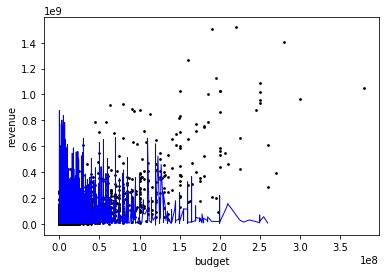

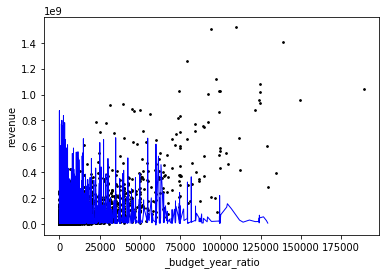

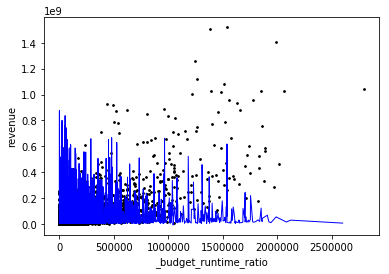

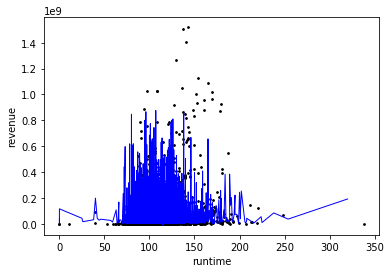

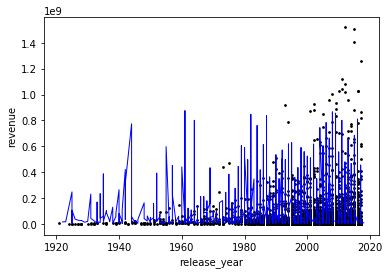

In [98]:
### LINEAR REGRESSION TRAINING
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

# filterItems = ['release_year', 'runtime']#, 'popularity', '_budget_runtime_ratio', '_budget_popularity_ratio', '_releaseYear_popularity_ratio', 'budget']
testItem = 'revenue'

## features based on correlation matrix
filterItems = ['budget', '_budget_year_ratio', '_budget_runtime_ratio', 'runtime', 'release_year']

testCols = test[filterItems]
testX = testCols.values.reshape(-1, len(filterItems))

trainCols = train[filterItems]
X = trainCols.values.reshape(-1, len(filterItems))
Y = train[testItem].values

linearModel = LinearRegression()
linearModel.fit(X, Y)

trainWithModel(X, Y, testX, filterItems, testItem, linearModel, 'linearRegression')


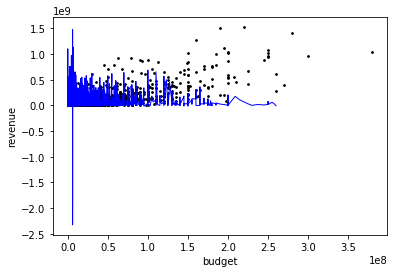

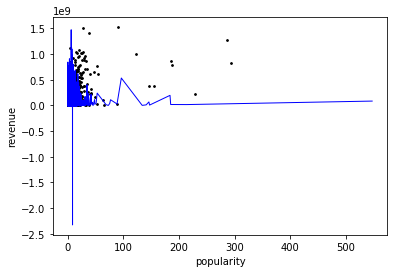

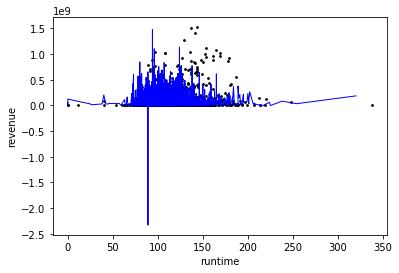

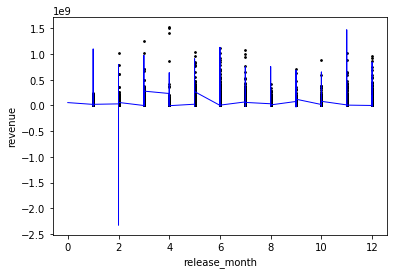

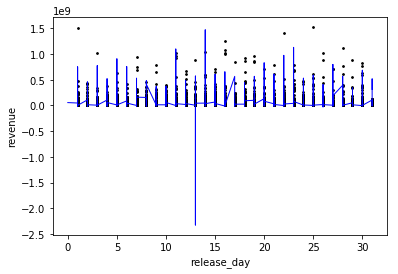

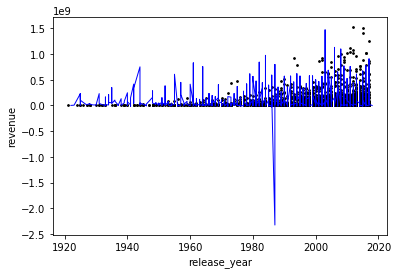

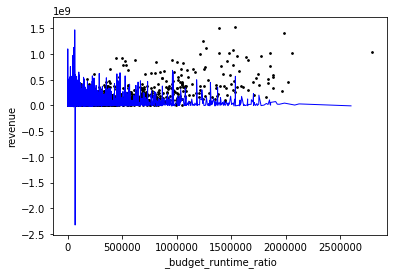

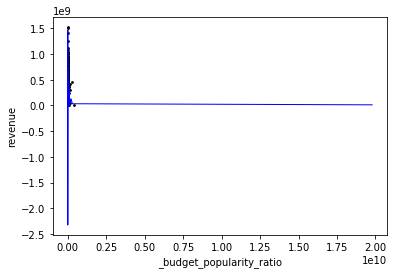

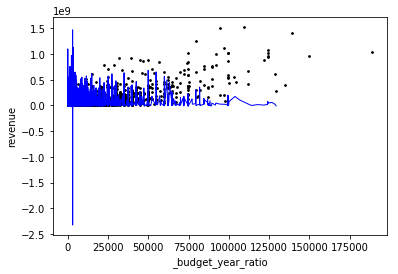

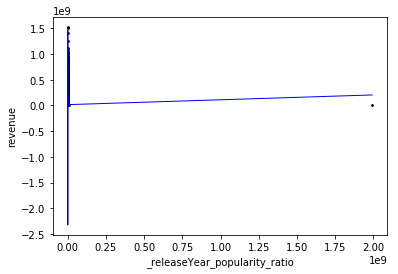

In [116]:
### Ridge regression
from sklearn.linear_model import RidgeCV

# filterItems = ['release_year', 'runtime', 'popularity', '_budget_runtime_ratio', '_budget_popularity_ratio', '_releaseYear_popularity_ratio', 'budget']
filterItems = [
'budget'
,'popularity'
,'runtime'
,'release_month'
,'release_day'
,'release_year'
,'_budget_runtime_ratio'
,'_budget_popularity_ratio'
,'_budget_year_ratio'
,'_releaseYear_popularity_ratio'
# ,'_popularity_releaseYear_ratio'
# ,'isMovieReleased'
# ,'isOriginalLanguageEng'
# ,'meanRuntimeByYear'
### Last Four Items contain ill-conditioned data
]


target = 'revenue'


testCols = test[filterItems]
testX = testCols.values.reshape(-1, len(filterItems))

trainCols = train[filterItems]
X = trainCols.values.reshape(-1, len(filterItems))
Y = train[testItem].values

ridgeModel = RidgeCV(cv=5)
ridgeModel.fit(X, Y)

trainWithModel(X, Y, testX, filterItems, target, ridgeModel, 'ridgeRegression')

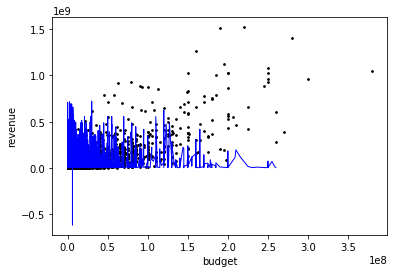

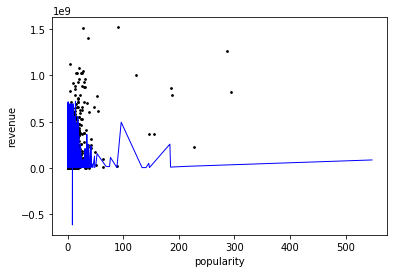

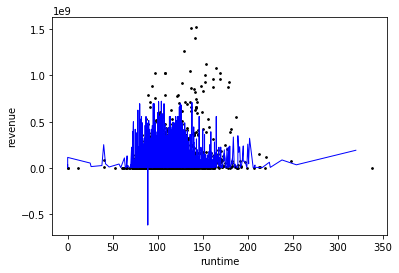

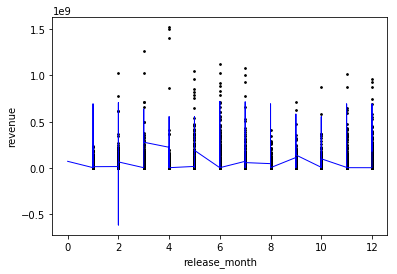

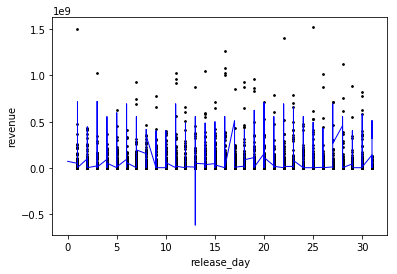

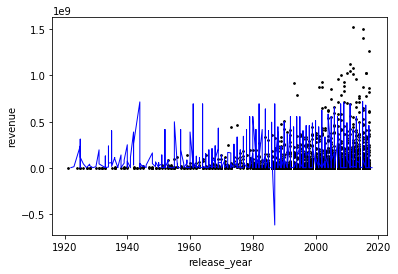

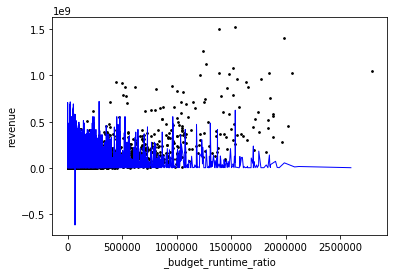

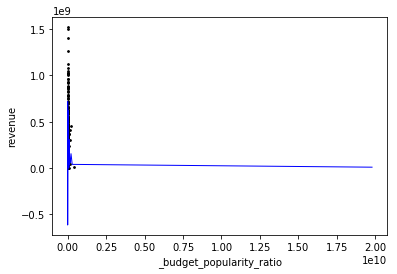

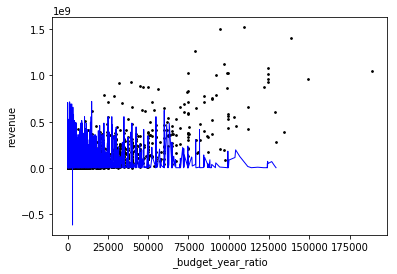

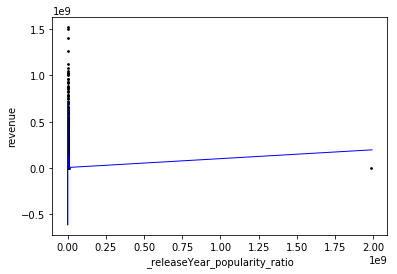

In [118]:
### Ridge regression and Lasso regression
from sklearn.linear_model import LassoCV

# filterItems = ['release_year', 'runtime', 'popularity', '_budget_runtime_ratio', '_budget_popularity_ratio', '_releaseYear_popularity_ratio', 'budget']
filterItems = [
'budget'
,'popularity'
,'runtime'
,'release_month'
,'release_day'
,'release_year'
,'_budget_runtime_ratio'
,'_budget_popularity_ratio'
,'_budget_year_ratio'
,'_releaseYear_popularity_ratio'
# ,'_popularity_releaseYear_ratio'
# ,'isMovieReleased'
# ,'isOriginalLanguageEng'
# ,'meanRuntimeByYear'
### Last Four Items contain ill-conditioned data
]

target = 'revenue'


testCols = test[filterItems]
testX = testCols.values.reshape(-1, len(filterItems))

trainCols = train[filterItems]
X = trainCols.values.reshape(-1, len(filterItems))
Y = train[testItem].values

lassoModel = LassoCV(cv=5)
lassoModel.fit(X, Y)

trainWithModel(X, Y, testX, filterItems, target, lassoModel, 'lassoRegression')